# Рубежный контроль №2
## Тема: Методы обработки текстов. Решение задачи классификации.
    
### Выполнила:
Румак Дарья Павловна
### Группа:
ИУ5-22М

## Цель работы
Целью работы является решение задачи бинарной классификации текстов. На примере датасета SMS-сообщений необходимо построить и оценить модели машинного обучения для определения, является ли сообщение спамом (spam) или обычным сообщением (ham). В ходе работы будут сравнены два метода векторизации текста (CountVectorizer и TfidfVectorizer) и два алгоритма классификации (RandomForestClassifier и LogisticRegression).

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Утилиты для работы с файлами и запросами
import os
import re
import zipfile
import urllib.request

# Библиотеки для обработки текста (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Загрузка стоп-слов
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Загрузка и сохранение датасета
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
file_name = "smsspamcollection.zip"
data_dir = "smsspamcollection"

if not os.path.exists(data_dir):
    urllib.request.urlretrieve(url, file_name)
    with zipfile.ZipFile(file_name, "r") as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(file_name)

# Загрузка данных в DataFrame
file_path = os.path.join(data_dir, "SMSSpamCollection")
df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'text'])

In [3]:
# Преобразование текстовой метки в числовую (0 - ham, 1 - spam)
df['target'] = df['label'].map({'ham': 0, 'spam': 1})

In [4]:
print(df.head())

  label                                               text  target
0   ham  Go until jurong point, crazy.. Available only ...       0
1   ham                      Ok lar... Joking wif u oni...       0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...       1
3   ham  U dun say so early hor... U c already then say...       0
4   ham  Nah I don't think he goes to usf, he lives aro...       0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
 2   target  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


Оценим баланс классов, то есть соотношение спам-сообщений к обычным.

In [6]:
# Распределение классов
df['label'].value_counts()

,count
label,
ham,4825
spam,747


Как видно, классы несбалансированы: обычных сообщений (ham) значительно больше, чем спама (spam). Учтем это при разделении данных на обучающую и тестовую выборки, используем стратификацию.

Текстовые данные необходимо очистить от "шума" (знаков препинания, цифр, стоп-слов) и привести слова к их основной форме (стемминг).

In [7]:
# Инициализация стеммера и стоп-слов для английского языка
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Удаление спецсимволов и чисел
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов и стемминг
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

# Применение функции предобработки
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Проверка результата
print("Текст до обработки:\n", df['text'][0])
print("\nТекст после обработки:\n", df['cleaned_text'][0])

Текст до обработки:
 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Текст после обработки:
 jurong point crazi avail bugi great world buffet cine got amor wat


Разделим данные на обучающую и тестовую выборки. Затем преобразуем очищенный текст в числовые векторы с помощью CountVectorizer и TfidfVectorizer.

In [8]:
# Разделение данных
X = df['cleaned_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 4457
Размер тестовой выборки: 1115


In [9]:
# Векторизация с помощью CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"\nРазмерность CountVectorizer (train): {X_train_counts.shape}")
print(f"Размерность CountVectorizer (test): {X_test_counts.shape}")


Размерность CountVectorizer (train): (4457, 5000)
Размерность CountVectorizer (test): (1115, 5000)


In [10]:
# Векторизация с помощью TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nРазмерность TfidfVectorizer (train): {X_train_tfidf.shape}")
print(f"Размерность TfidfVectorizer (test): {X_test_tfidf.shape}")


Размерность TfidfVectorizer (train): (4457, 5000)
Размерность TfidfVectorizer (test): (1115, 5000)


In [11]:
# Словарь для хранения результатов
results = {}

def train_and_evaluate_model(model, X_train_vec, y_train_data, X_test_vec, y_test_data, model_name, vectorizer_name):
    print(f"--- Обучение и оценка: {model_name} c {vectorizer_name} ---")

    # Обучение
    model.fit(X_train_vec, y_train_data)

    # Предсказание
    y_pred = model.predict(X_test_vec)

    # Оценка
    accuracy = accuracy_score(y_test_data, y_pred)
    report = classification_report(y_test_data, y_pred, target_names=['Ham', 'Spam'])

    print(f"Точность (Accuracy): {accuracy:.4f}")
    print("Отчет по классификации:")
    print(report)

    # Матрица ошибок
    cm = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Матрица ошибок: {model_name} c {vectorizer_name}')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

    return {'model': model_name, 'vectorizer': vectorizer_name, 'accuracy': accuracy}

Проведем четырые эксперимента

--- Обучение и оценка: RandomForestClassifier c CountVectorizer ---
Точность (Accuracy): 0.9731
Отчет по классификации:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.80      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



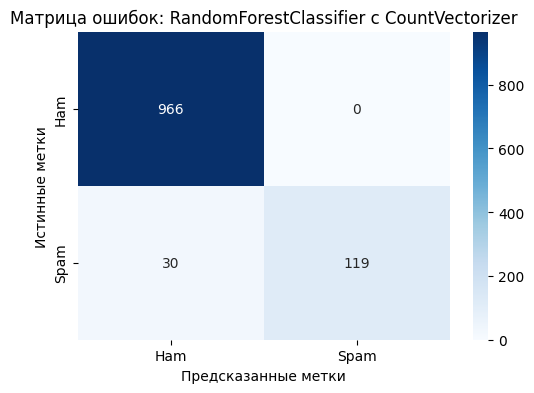

In [12]:
# 1. RandomForestClassifier + CountVectorizer
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
results['rf_count'] = train_and_evaluate_model(rf_model, X_train_counts, y_train, X_test_counts, y_test, "RandomForestClassifier", "CountVectorizer")

--- Обучение и оценка: RandomForestClassifier c TfidfVectorizer ---
Точность (Accuracy): 0.9749
Отчет по классификации:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



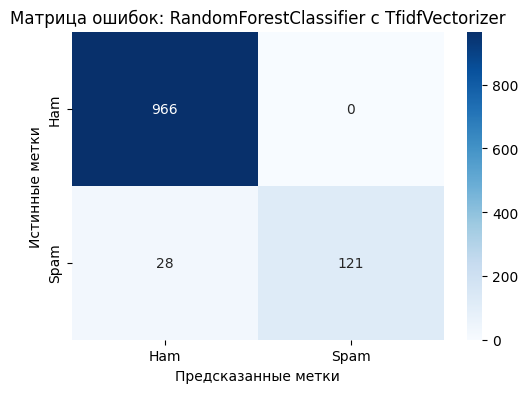

In [13]:
# 2. RandomForestClassifier + TfidfVectorizer
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
results['rf_tfidf'] = train_and_evaluate_model(rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "RandomForestClassifier", "TfidfVectorizer")

--- Обучение и оценка: LogisticRegression c CountVectorizer ---
Точность (Accuracy): 0.9839
Отчет по классификации:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



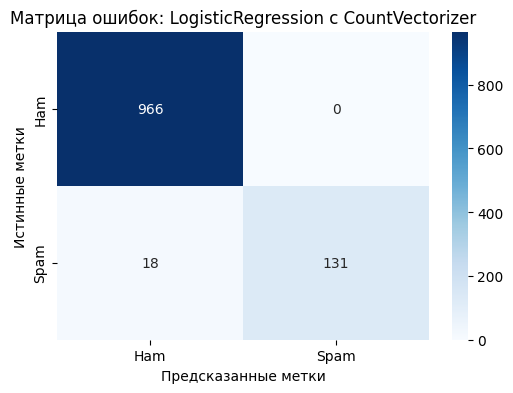

In [14]:
# 3. LogisticRegression + CountVectorizer
lr_model = LogisticRegression(max_iter=1000, random_state=42)
results['lr_count'] = train_and_evaluate_model(lr_model, X_train_counts, y_train, X_test_counts, y_test, "LogisticRegression", "CountVectorizer")

--- Обучение и оценка: LogisticRegression c TfidfVectorizer ---
Точность (Accuracy): 0.9668
Отчет по классификации:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



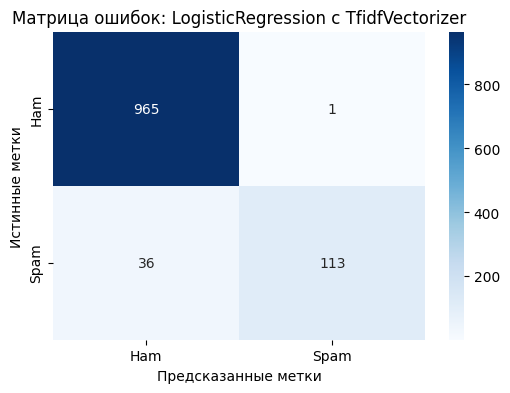

In [15]:
# 4. LogisticRegression + TfidfVectorizer
lr_model = LogisticRegression(max_iter=1000, random_state=42)
results['lr_tfidf'] = train_and_evaluate_model(lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, "LogisticRegression", "TfidfVectorizer")

Сравним точность всех четырех подходов в виде таблицы и графика, чтобы наглядно определить лучшую комбинацию.

In [16]:
# Сравнение результатов
df_comparison = pd.DataFrame(list(results.values()))
print(df_comparison.sort_values(by='accuracy', ascending=False))

                    model       vectorizer  accuracy
2      LogisticRegression  CountVectorizer  0.983857
1  RandomForestClassifier  TfidfVectorizer  0.974888
0  RandomForestClassifier  CountVectorizer  0.973094
3      LogisticRegression  TfidfVectorizer  0.966816


Как видно, лучшие модели LogisticRegression + CountVectorizer с точностью 0.9839

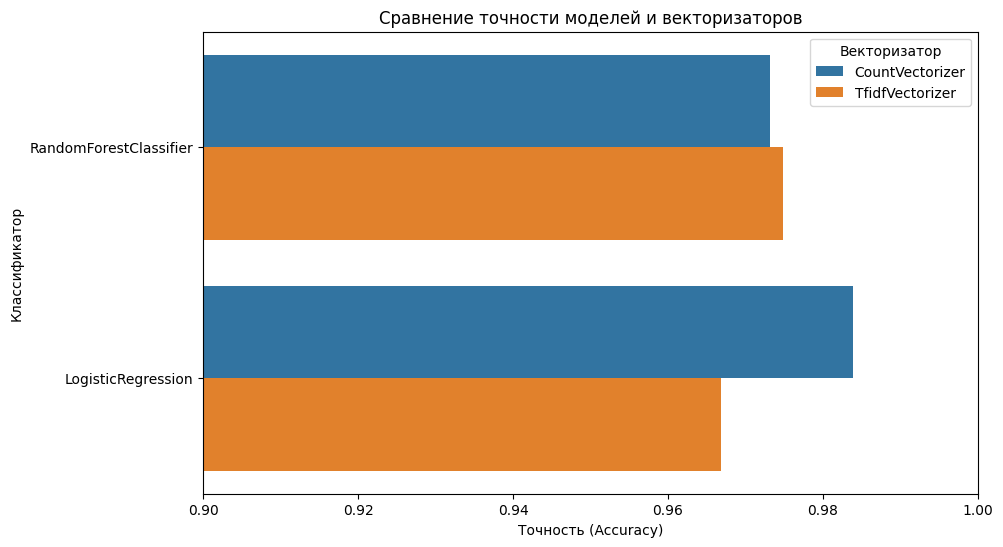

In [17]:
# Визуализация сравнения
plt.figure(figsize=(10, 6))
sns.barplot(x='accuracy', y='model', hue='vectorizer', data=df_comparison)
plt.title('Сравнение точности моделей и векторизаторов')
plt.xlabel('Точность (Accuracy)')
plt.ylabel('Классификатор')
plt.xlim(0.9, 1.0)
plt.legend(title='Векторизатор')
plt.show()

### Выводы:
1. Обе модели, LogisticRegression и RandomForestClassifier, показали очень высокие результаты на данной задаче.
2. LogisticRegression продемонстрировала незначительно лучшую точность по сравнению с RandomForestClassifier для обоих типов векторизации.
3. Векторизатор TfidfVectorizer дал небольшое преимущество в точности для обеих моделей по сравнению с CountVectorizer.

Анализ по матрицам ошибок: Лучшая модель (LogisticRegression + CountVectorizer) допустила всего 18 ошибок на 1115 тестовых сообщениях. При этом она не пропустила ни одного спам-сообщения (Recall для класса Spam = 0.88), что является хорошим показателем, хотя и не идеальным (18 спам-сообщений были классифицированы как ham).

### В итоге:
Наилучшей комбинацией для решения задачи классификации SMS-спама на данном датасете является Логистическая регрессия с признаками, полученными с помощью CountVectorizer.